In [200]:
import sys, os
sys.path.append('/home/A00512318/TCN')
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from TCN.mnist_pixel.utils import data_generator
from TCN.mnist_pixel.model import TCN
import numpy as np
import argparse

# set default values for model
batch_size = 100
cuda = True
dropout = 0.10
clip = -1
epochs = 20
kernel_size = 5
levels = 12
log_interval = 100
lr = 2e-3
optimm = 'Adam'
nhid = 25
seed = 1111
permutee = False
root = '../data/fashion_mnist'
save_filename = './checkpoints/fashionmnist/fashionmnist_real_0.3_levels_12.pt'
input_channels = 1
n_classes = 10
seq_length = int(784 / input_channels)
steps = 0

In [201]:
from torchvision import datasets, transforms

def data_generator(root, batch_size):
    train_set = datasets.FashionMNIST(root=root, train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))
    test_set = datasets.FashionMNIST(root=root, train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

train_loader, test_loader = data_generator(root, batch_size)

classes = ('tshit/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle/boot')
# print(classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ankle/boot tshit/top tshit/top dress tshit/top pullover sneaker pullover sandal sandal tshit/top ankle/boot sandal sandal sneaker ankle/boot trouser tshit/top shirt  coat dress trouser  coat   bag  coat dress tshit/top pullover  coat  coat sandal dress


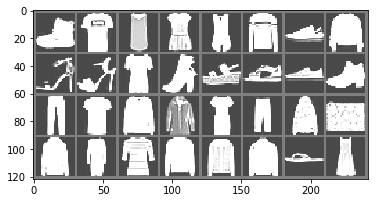

In [202]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

unique_images = {}
seen = set()
for i in range(batch_size):
    if labels[i] not in seen:
        seen.add(labels[i].item())
#         print(seen)
        unique_images[labels[i].item()] = images[i]

# print([label[0] for label in unique_images])
# print(seen)
# print(labels)
# print()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [203]:
def plot_sample_predictions(classes, images):
    """
    This function displays images randomly and tries to predict the correct class
    stolen from here: https://github.com/cmasch/zalando-fashion-mnist/blob/master/Simple_Convolutional_Neural_Network_Fashion-MNIST.ipynb
    """

    class_ = 0
    images_per_row = 5
    rows = len(classes) // images_per_row
#     print(rows)
    ii = 0;
    for i in range(rows):
        fig, axis = plt.subplots(1, images_per_row)
     
        for i, axis in enumerate(axis):
#             print(axis, i)
            fig.set_size_inches(15, 25)
            axis.text(0,36,classes[ii])
            axis.imshow(images[ii][0] / 2 + 0.5, cmap='gray')
            axis.axis('off')
            class_ +=1
            ii += 1
    plt.show()
    plt.savefig('./classes.png')

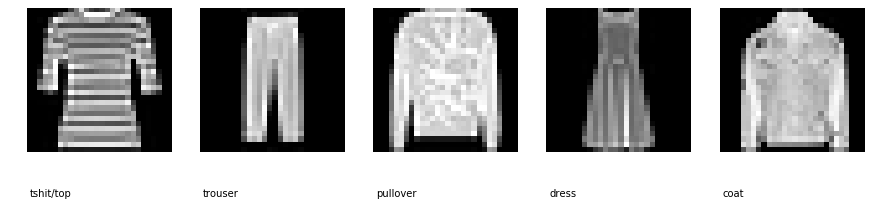

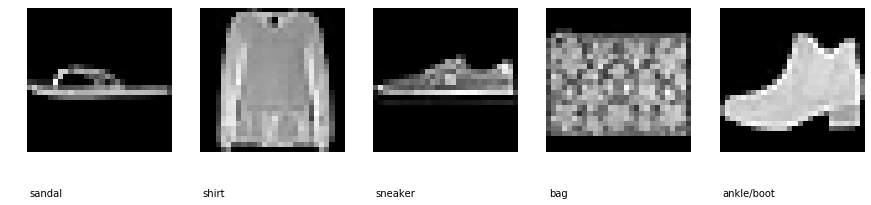

<Figure size 432x288 with 0 Axes>

In [204]:
# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])
# fig

dataiter = iter(train_loader)
images, labels = dataiter.next()
plot_sample_predictions(classes, unique_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8])
ankle/boot pullover trouser trouser shirt trouser  coat shirt sandal sneaker  coat sandal sneaker dress  coat trouser pullover  coat   bag tshit/top pullover sandal sneaker ankle/boot trouser  coat shirt tshit/top ankle/boot dress   bag   bag


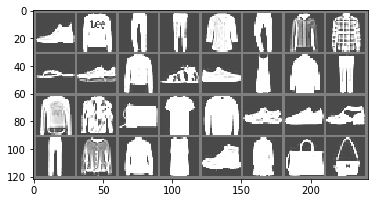

In [205]:
# sanity check for validation data
dataiter = iter(test_loader)
images, labels = dataiter.next()
print(labels)
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [206]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
channel_sizes = [nhid] * levels
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)

model = nn.DataParallel(model)
model.to(device)

# permute = permute.cuda()
permute = permute.to(device)
optimizer = getattr(optim, optimm)(model.parameters(), lr=lr)

In [207]:
def trainTCN(ep):
    global steps
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda: 
            data, target = data.to(device), target.to(device)
        data = data.view(-1, input_channels, seq_length)
        if permutee:
            data = data[:, :, permute]
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        if clip > 0:
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()
        train_loss += loss.item()
#         loss_.append(train_loss)
        steps += seq_length
        if batch_idx > 0 and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tSteps: {}'.format(
                ep, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss/log_interval, steps))
            train_loss = 0

In [208]:
def testTCN():
    test_loss = 0
    correct = 0
    correct_class = list(0. for i in range(10))
    correct_total = list(0. for i in range(10))
    tot = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.to(device), target.to(device)
            data = data.view(-1, input_channels, seq_length)
            if permutee:
                data = data[:, :, permute]
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            _, pred = torch.max(output, 1)
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
#             print(len(target.data.view_as(pred)))
            c = (pred == target).squeeze()
            tot += 1
#             if tot != 313:
#             for i in range(len(test_loader.dataset) // batch_size):
# #                     print(pred[i], target.data.view_as(pred)[i])
#                 print(i)
#                 label = pred[i]
#                 if (pred[i] == target.data.view_as(pred)[i]):
#                     correct_class[label] += c[i].item()
#                 correct_total[label] += 1
                    
                
#     print(tot)
#     for i in range(10):
#         print('Accuracy of %5s : %2d %%' % (
#             classes[i], 100 * correct_class[i] / correct_total[i]))

    test_loss /= len(test_loader.dataset)
#     print(correct.item())
    accuracy_.append(correct.item() / 10000.)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [209]:
def save(model):
    torch.save(model, save_filename)
    print('Saved as %s' % save_filename)

In [210]:
accuracy_ = []
loss_ = []
# def runModel():
for epoch in range(1, epochs+1):
    trainTCN(epoch)
    testTCN()
    if epoch % 5 == 0: 
        print('Saving model.....')
        save(model) 
    if epoch % 10 == 0:
        lr /= 10
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            

Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.487833	Steps: 79184
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.761971	Steps: 157584
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.665912	Steps: 235984
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.608739	Steps: 314384
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.563143	Steps: 392784
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.542722	Steps: 471184
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.520634	Steps: 549584
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.495145	Steps: 627984
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.473880	Steps: 706384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.461656	Steps: 784784
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.449888	Steps: 863184
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.463560	Steps: 941584
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.434449	Steps: 1019984
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.421822	Steps: 1098384
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.426147	Steps: 1176784
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0

Train Epoch: 7 [41600/60000 (69%)]	Loss: 0.280852	Steps: 9839984
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.264072	Steps: 9918384
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.281610	Steps: 9996784
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.274264	Steps: 10075184
Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.291004	Steps: 10153584
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.284213	Steps: 10231984

Test set: Average loss: 0.3250, Accuracy: 8846/10000 (88%)

Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.285662	Steps: 10369184
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.256037	Steps: 10447584
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.261186	Steps: 10525984
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.250182	Steps: 10604384
Train Epoch: 8 [16000/60000 (27%)]	Loss: 0.266840	Steps: 10682784
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.304871	Steps: 10761184
Train Epoch: 8 [22400/60000 (37%)]	Loss: 0.265787	Steps: 10839584
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.259331	Steps: 10917984
Train Epoch: 8 [28800/

Train Epoch: 14 [9600/60000 (16%)]	Loss: 0.197536	Steps: 19345984
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.204463	Steps: 19424384
Train Epoch: 14 [16000/60000 (27%)]	Loss: 0.214379	Steps: 19502784
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.220010	Steps: 19581184
Train Epoch: 14 [22400/60000 (37%)]	Loss: 0.214616	Steps: 19659584
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.192016	Steps: 19737984
Train Epoch: 14 [28800/60000 (48%)]	Loss: 0.207096	Steps: 19816384
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.222850	Steps: 19894784
Train Epoch: 14 [35200/60000 (59%)]	Loss: 0.204034	Steps: 19973184
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.204990	Steps: 20051584
Train Epoch: 14 [41600/60000 (69%)]	Loss: 0.213222	Steps: 20129984
Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.197413	Steps: 20208384
Train Epoch: 14 [48000/60000 (80%)]	Loss: 0.203507	Steps: 20286784
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.203497	Steps: 20365184
Train Epoch: 14 [54400/60000 (91%)]	Loss: 0.213827	Steps: 20443

Train Epoch: 20 [35200/60000 (59%)]	Loss: 0.197106	Steps: 28793184
Train Epoch: 20 [38400/60000 (64%)]	Loss: 0.203154	Steps: 28871584
Train Epoch: 20 [41600/60000 (69%)]	Loss: 0.204785	Steps: 28949984
Train Epoch: 20 [44800/60000 (75%)]	Loss: 0.182142	Steps: 29028384
Train Epoch: 20 [48000/60000 (80%)]	Loss: 0.190449	Steps: 29106784
Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.197053	Steps: 29185184
Train Epoch: 20 [54400/60000 (91%)]	Loss: 0.197377	Steps: 29263584
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.200195	Steps: 29341984

Test set: Average loss: 0.2722, Accuracy: 9010/10000 (90%)

Saving model.....
Saved as ./checkpoints/fashionmnist/fashionmnist_real_0.3_levels_12.pt


In [218]:
loaded_model = None
with open(save_filename, 'rb') as f:
        loaded_model = torch.load(f)
#         print(model)
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

73510

In [407]:
loaded_model.to(device)
# kernel = loaded_model.module.tcn.network[0].net[0].weight.data.clone()
# kernel.shape
# kernel
# loaded_model.module.tcn.network
loaded_model.module.tcn.network[0].net

Sequential(
  (0): Conv1d(1, 25, kernel_size=(5,), stride=(1,), padding=(4,))
  (1): Chomp1d()
  (2): ReLU()
  (3): Dropout(p=0.05)
  (4): Conv1d(25, 25, kernel_size=(5,), stride=(1,), padding=(4,))
  (5): Chomp1d()
  (6): ReLU()
  (7): Dropout(p=0.05)
)

<Figure size 432x288 with 0 Axes>

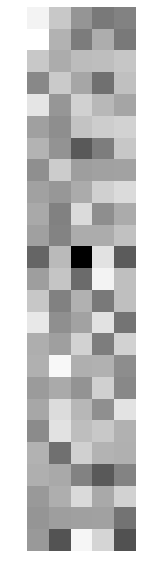

In [403]:
fig = plt.figure()
plt.figure(figsize=(10,10))
for idx, filt  in enumerate(kernel):
#     print(filt[0, :])
#     print(filt[0, :])
#     plt.subplot(4,7, idx + 1)
    plt.imshow(filt, cmap="gray")
    plt.axis('off')
    
    
fig.show()

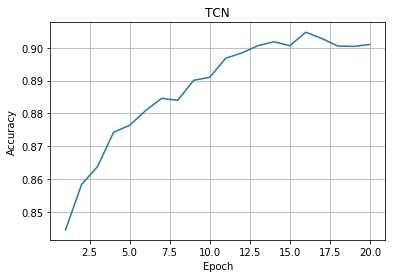

In [213]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(1, 21)
# s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, accuracy_)

ax.set(xlabel='Epoch', ylabel='Accuracy',
       title='TCN')
ax.grid()

fig.savefig("test.png")
plt.show()

In [221]:
mode

AttributeError: 'DataParallel' object has no attribute 'weights'

In [217]:
model.to

DataParallel(
  (module): TCN(
    (tcn): TemporalConvNet(
      (network): Sequential(
        (0): TemporalBlock(
          (conv1): Conv1d(1, 25, kernel_size=(5,), stride=(1,), padding=(4,))
          (chomp1): Chomp1d()
          (relu1): ReLU()
          (dropout1): Dropout(p=0.05)
          (conv2): Conv1d(25, 25, kernel_size=(5,), stride=(1,), padding=(4,))
          (chomp2): Chomp1d()
          (relu2): ReLU()
          (dropout2): Dropout(p=0.05)
          (net): Sequential(
            (0): Conv1d(1, 25, kernel_size=(5,), stride=(1,), padding=(4,))
            (1): Chomp1d()
            (2): ReLU()
            (3): Dropout(p=0.05)
            (4): Conv1d(25, 25, kernel_size=(5,), stride=(1,), padding=(4,))
            (5): Chomp1d()
            (6): ReLU()
            (7): Dropout(p=0.05)
          )
          (downsample): Conv1d(1, 25, kernel_size=(1,), stride=(1,))
          (relu): ReLU()
        )
        (1): TemporalBlock(
          (conv1): Conv1d(25, 25, kernel_size